LOAD DATA 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

data_path = os.path.join(sys.path[0], "../data/Task 2/sample_1a2bc3012c9defca.npz")

In [2]:
info = np.load(data_path,allow_pickle=True)
all_agent_trajs        = info['all_agent']    
all_agent_trajs.shape  #[24 agents, 91 timesteps the interval between each timestep is 0.1 second,\
    #10 denotes [center_x, center_y, center_z, boundingbox_x, boundingbox_y, boundingbox_z, heading, vel_x, vel_y, valid] ]
#the valid flag is either 0 or 1. 1 means the valid, 0 means invalid
obj_types              = info['object_type']
lane_polylines         = info['lane']           #  list of [n,7] array [x,y,z,ori_x,ori_y,ori_z,type]
road_polylines         = info['road_polylines'] #  list of [n,7] array [x,y,z,ori_x,ori_y,ori_z,type]
crosswalk_polylines    = info['crosswalk']      #  list of [n,7] array [x,y,z,ori_x,ori_y,ori_z,type]
speed_bump_polylines   = info['speed_bump']     #  list of [n,7] array [x,y,z,ori_x,ori_y,ori_z,type]
stop_signs_polylines   = info['stop_sign']      #  list of [n,7] array [x,y,z,ori_x,ori_y,ori_z,type]
drive_way_polylines    = info['drive_way']      #  list of [n,7] array [x,y,z,ori_x,ori_y,ori_z,type]


We select the 11th timestep as the current timestep 

In [3]:
curr_time_idx = 10
all_agent_current = all_agent_trajs[:, curr_time_idx]
all_agent_current.shape

(24, 10)

In [4]:
#ground truth for the future 1s,2s,3s can be easily derived by :
predict_horizon = [10, 20, 30]  # 0.1s unit
all_gt_future = {
    10: all_agent_trajs[:, 11 : 11 + 10],
    20: all_agent_trajs[:, 11 : 11 + 20],
    30: all_agent_trajs[:, 11 : 11 + 30],
}


Index of target agnet to preict

In [5]:
tracks        = info['predict_list']  
tracks
agents_to_predict = all_agent_trajs[tracks]
agents_to_predict.shape

(8, 91, 10)

The homework should be done on these 8 agents.

Q1.Using constant velocity model to predict the future (1s,2s,3s) trajectories of the target agent and calculate the ADE and FDE.  

In [6]:
import sys
import copy

sys.path.append("../")
from utils import calcu_ade, calcu_fde


def forward_step(dt, pos, vel, acc=[0, 0]):
    """simulate the physics step forward

    Args:
        state (list): [center_x, center_y, center_z, boundingbox_x, boundingbox_y, boundingbox_z, heading, vel_x, vel_y, valid]
        dt (_type_): _description_
    """
    new_x = pos[0] + vel[0] * dt + 0.5 * acc[0] * dt**2
    new_y = pos[1] + vel[1] * dt + 0.5 * acc[1] * dt**2
    new_vel_x = vel[0] + acc[0] * dt
    new_vel_y = vel[1] + acc[1] * dt
    return [new_x, new_y], [new_vel_x, new_vel_y]


def forward_step_ctrv(dt, pos, vel):
    """simulate the physics step forward

    Args:
        pos (list): [x, y, theta]
        dt (_type_): delta time
        vel (list): [vel,omega]
    """
    new_x = pos[0] + vel[0] / vel[1] * np.sin(pos[2] + vel[1] * dt) - vel[0] / vel[1] * np.sin(pos[2])
    new_y = pos[1] - vel[0] / vel[1] * np.cos(pos[2] + vel[1] * dt) + vel[0] / vel[1] * np.cos(pos[2])
    new_heading = pos[2] + vel[1] * dt
    return [new_x, new_y, new_heading]


metric_template = {
    10: {"ade": {"const_vel": 0, "const_acc": 0, "ctrv": 0}, "fde": {"const_vel": 0, "const_acc": 0, "ctrv": 0}},
    20: {"ade": {"const_vel": 0, "const_acc": 0, "ctrv": 0}, "fde": {"const_vel": 0, "const_acc": 0, "ctrv": 0}},
    30: {"ade": {"const_vel": 0, "const_acc": 0, "ctrv": 0}, "fde": {"const_vel": 0, "const_acc": 0, "ctrv": 0}},
}
predicted_template = {
    10: {"const_vel": [], "const_acc": [], "ctrv": []},
    20: {"const_vel": [], "const_acc": [], "ctrv": []},
    30: {"const_vel": [], "const_acc": [], "ctrv": []},
}
dt = 0.1
predict_result = {}
metric_all = {}

for track in tracks:
    predicted = copy.deepcopy(predicted_template)  # use deepcopy to force a new memory allocation
    metric = copy.deepcopy(metric_template)

    for horizon in predict_horizon:

        # prepare initial state
        curr_state4vel = copy.deepcopy(all_agent_current[track])
        curr_pos4vel = curr_state4vel[:2]  # (x,y). pos used to predict vel-constant model-based prediction
        curr_vel4vel = curr_state4vel[7:9]  # (vel_x, vel_y)

        curr_state4acc = copy.deepcopy(all_agent_current[track])
        curr_pos4acc = curr_state4acc[:2]
        curr_vel4acc = curr_state4acc[7:9]
        acc = (all_agent_trajs[track][curr_time_idx][7:9] - all_agent_trajs[track][curr_time_idx - 1][7:9]) / dt

        curr_state4ctrv = copy.deepcopy(all_agent_current[track])
        curr_pos4ctrv = np.append(curr_state4ctrv[:2], curr_state4ctrv[6])  # (x, y, theta)
        vel = np.sqrt(curr_state4ctrv[7] ** 2 + curr_state4ctrv[8] ** 2)
        omega = (all_agent_trajs[track][curr_time_idx][6] - all_agent_trajs[track][curr_time_idx - 1][6]) / dt
        curr_vel4ctrv = np.array([vel, omega])

        for t in range(horizon):  # conduct the prediction

            predicted[horizon]["const_vel"].append(copy.deepcopy(curr_state4vel))
            predicted[horizon]["const_acc"].append(copy.deepcopy(curr_state4acc))
            predicted[horizon]["ctrv"].append(copy.deepcopy(curr_state4ctrv))

            # forward step
            curr_pos4vel, curr_vel4vel = forward_step(dt, curr_pos4vel, curr_vel4vel, [0, 0])
            curr_state4vel[:2] = curr_pos4vel
            curr_state4vel[7:9] = curr_vel4vel

            curr_pos4acc, curr_vel4acc = forward_step(dt, curr_pos4acc, curr_vel4acc, acc)
            curr_state4acc[:2] = curr_pos4acc
            curr_state4acc[7:9] = curr_vel4acc

            curr_pos4ctrv = forward_step_ctrv(dt, curr_pos4ctrv, curr_vel4ctrv)
            curr_state4ctrv[:2] = curr_pos4ctrv[:2]
            curr_state4ctrv[6] = curr_pos4ctrv[2]

        predicted[horizon]["const_vel"] = np.array(predicted[horizon]["const_vel"])
        predicted[horizon]["const_acc"] = np.array(predicted[horizon]["const_acc"])
        predicted[horizon]["ctrv"] = np.array(predicted[horizon]["ctrv"])

        # calculate evcaluation metrics
        ade_vel = calcu_ade(predicted[horizon]["const_vel"], all_gt_future[horizon][track])
        ade_acc = calcu_ade(predicted[horizon]["const_acc"], all_gt_future[horizon][track])
        fde_vel = calcu_fde(predicted[horizon]["const_vel"], all_gt_future[horizon][track])
        fde_acc = calcu_fde(predicted[horizon]["const_acc"], all_gt_future[horizon][track])
        ade_ctrv = calcu_ade(predicted[horizon]["ctrv"], all_gt_future[horizon][track])
        fde_ctrv = calcu_fde(predicted[horizon]["ctrv"], all_gt_future[horizon][track])

        metric[int(horizon)]["ade"]["const_vel"] = ade_vel
        metric[int(horizon)]["ade"]["const_acc"] = ade_acc
        metric[int(horizon)]["fde"]["const_vel"] = fde_vel
        metric[int(horizon)]["fde"]["const_acc"] = fde_acc
        metric[int(horizon)]["ade"]["ctrv"] = ade_ctrv
        metric[int(horizon)]["fde"]["ctrv"] = fde_ctrv

    metric_all[int(track)] = metric
    predict_result[int(track)] = predicted

Q2.Using constant acceleration model to predict the future (1s,2s,3s) trajectories of the target agent and calculate the ADE and FDE. 

In [7]:
# Q2 has been done in the above cell

Using Constant Turn Rate and Velocity(CTRV) model to predict the future (1s,2s,3s) trajectories of the target agent and calculate the ADE and FDE. 
$$
X_{k+1} = \begin{bmatrix}
x_k + \frac{v_k}{\omega_k} \sin(\theta_k + \omega_k T) - \frac{v_k}{\omega_k} \sin(\theta_k) \\
y_k - \frac{v_k}{\omega_k} \cos(\theta_k + \omega_k T) + \frac{v_k}{\omega_k} \cos(\theta_k) \\
\theta_k + \omega_k T \\
{v_k} \\
\omega_k
\end{bmatrix}

$$

In [8]:
# Q2 has been done in the above cell

Briefly discuss the observations from your results. 

Please see the report.

If you want to visualize the scenario here are some simple demo codes for you.

    'TYPE_FREEWAY': 1,
    'TYPE_SURFACE_STREET': 2,
    'TYPE_BIKE_LANE': 3,

    # for roadline
    'TYPE_UNKNOWN': -1,
    'TYPE_BROKEN_SINGLE_WHITE': 6,
    'TYPE_SOLID_SINGLE_WHITE': 7,
    'TYPE_SOLID_DOUBLE_WHITE': 8,
    'TYPE_BROKEN_SINGLE_YELLOW': 9,
    'TYPE_BROKEN_DOUBLE_YELLOW': 10,
    'TYPE_SOLID_SINGLE_YELLOW': 11,
    'TYPE_SOLID_DOUBLE_YELLOW': 12,
    'TYPE_PASSING_DOUBLE_YELLOW': 13,

    # for roadedge
    'TYPE_ROAD_EDGE_BOUNDARY': 15,
    'TYPE_ROAD_EDGE_MEDIAN': 16,

    # for stopsign
    'TYPE_STOP_SIGN': 17,

    # for crosswalk
    'TYPE_CROSSWALK': 18,

    # for speed bump
    'TYPE_SPEED_BUMP': 19,
    
    # for driveway
    'TYPE_DRIVEWAY': 20,

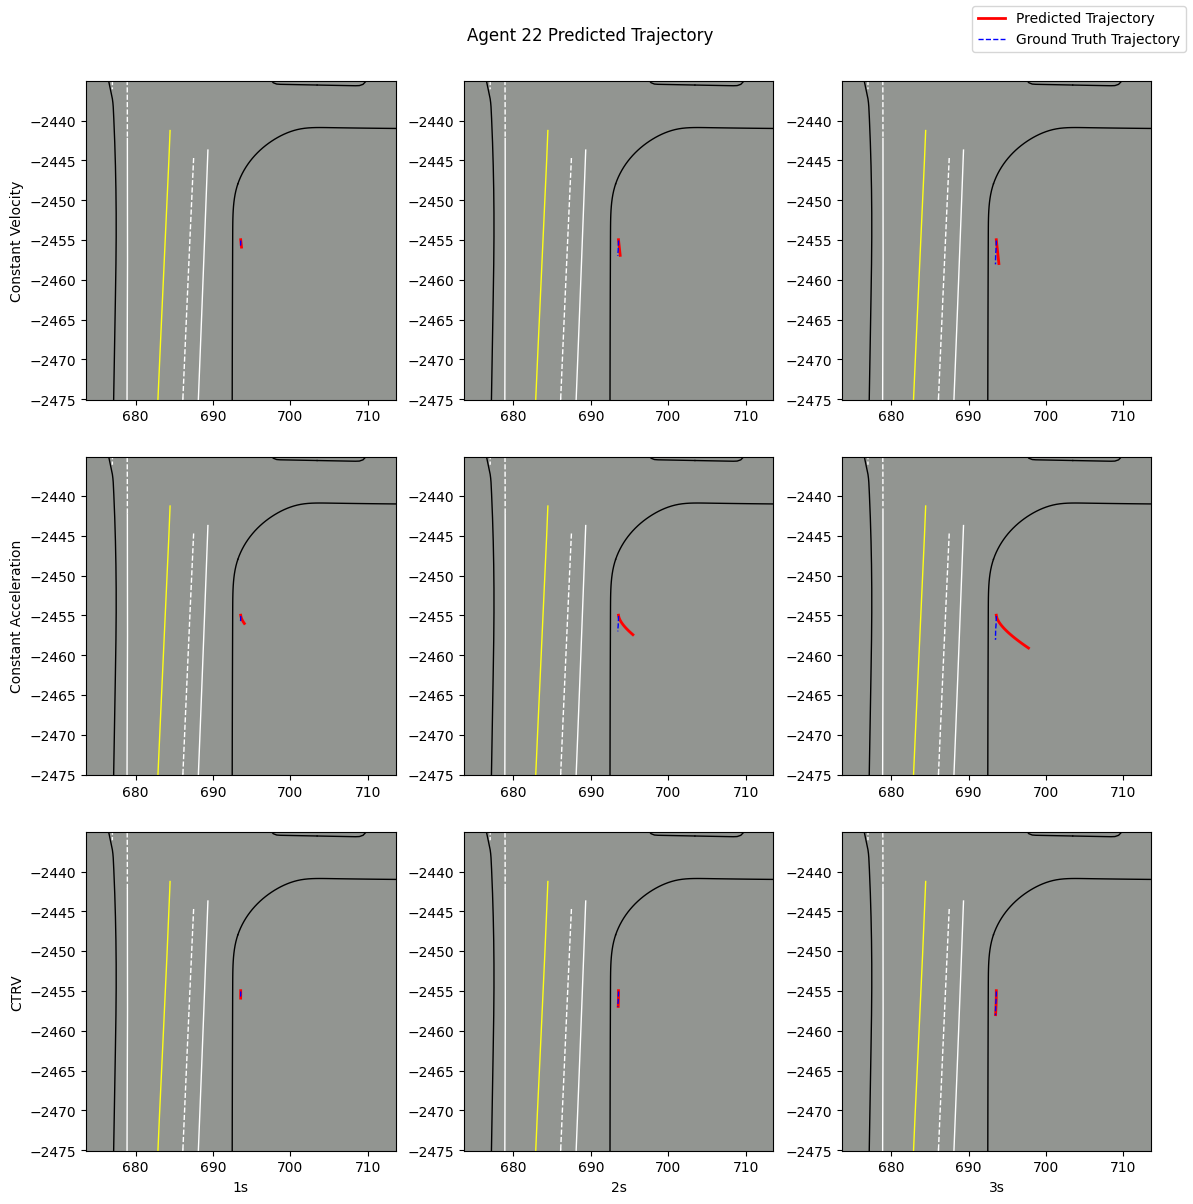

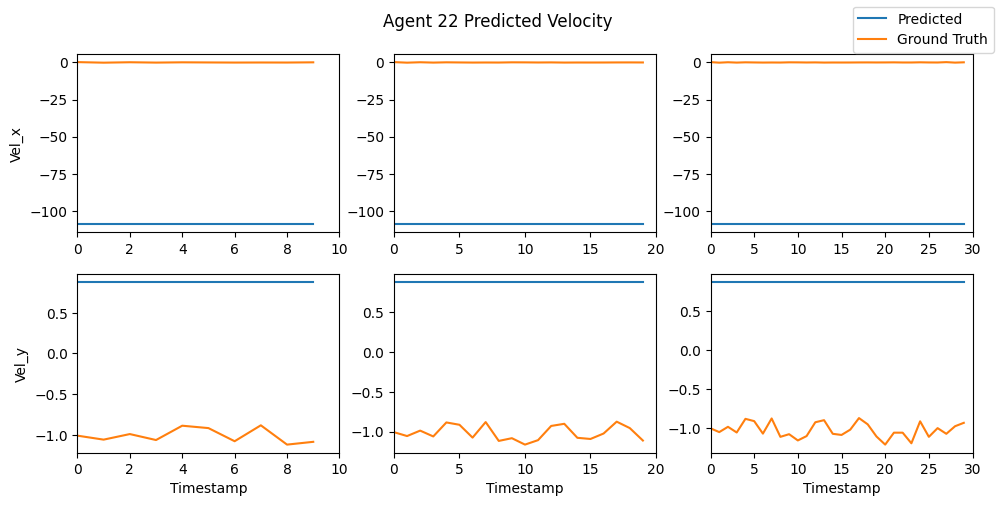

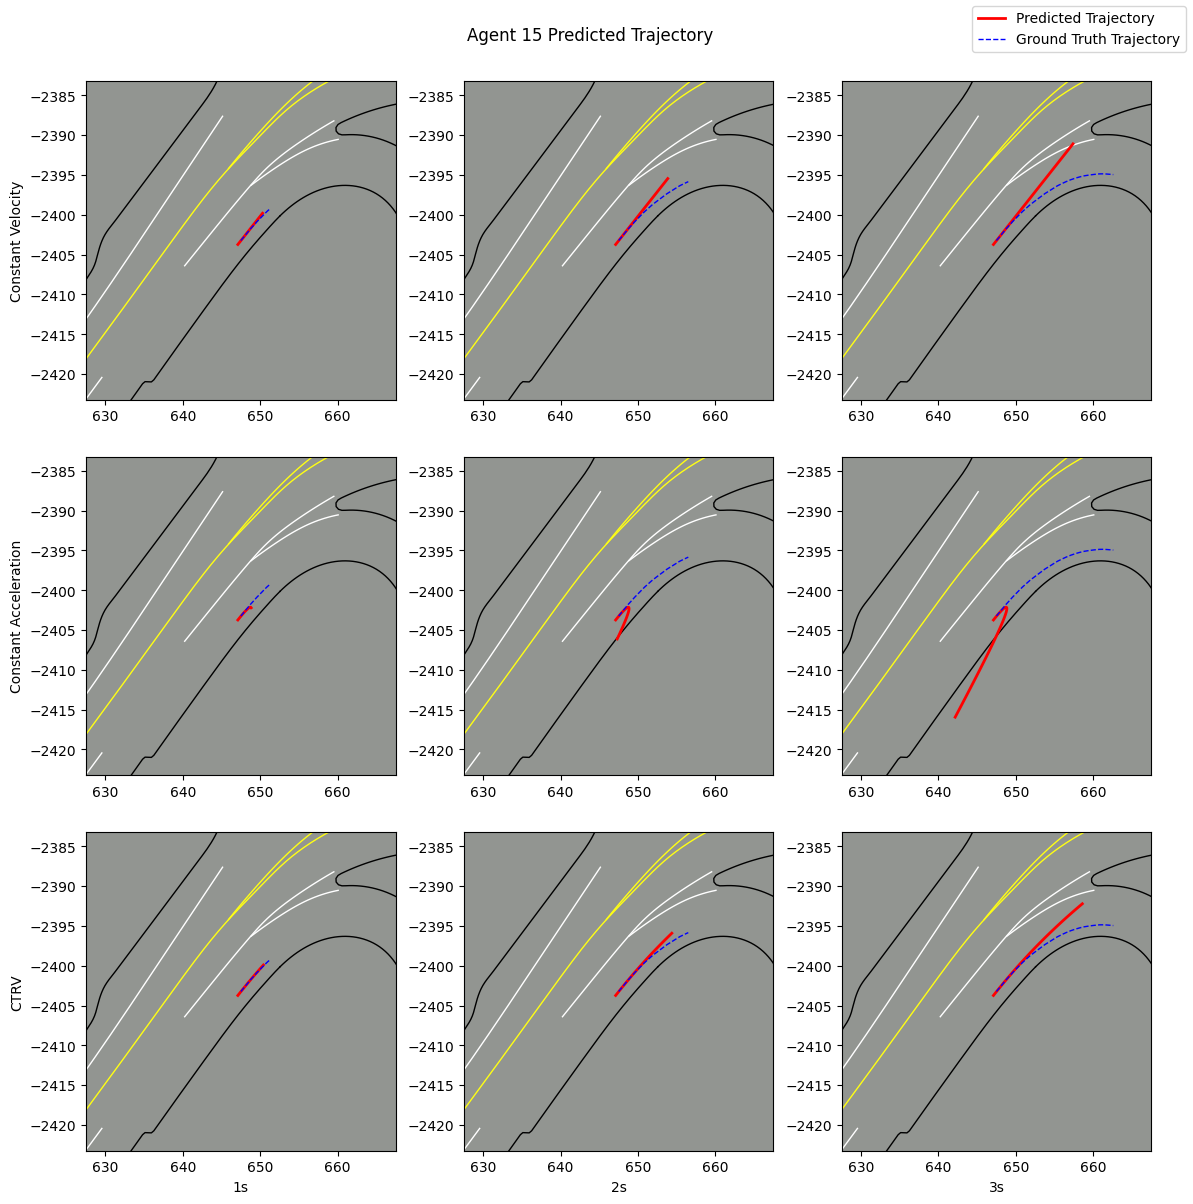

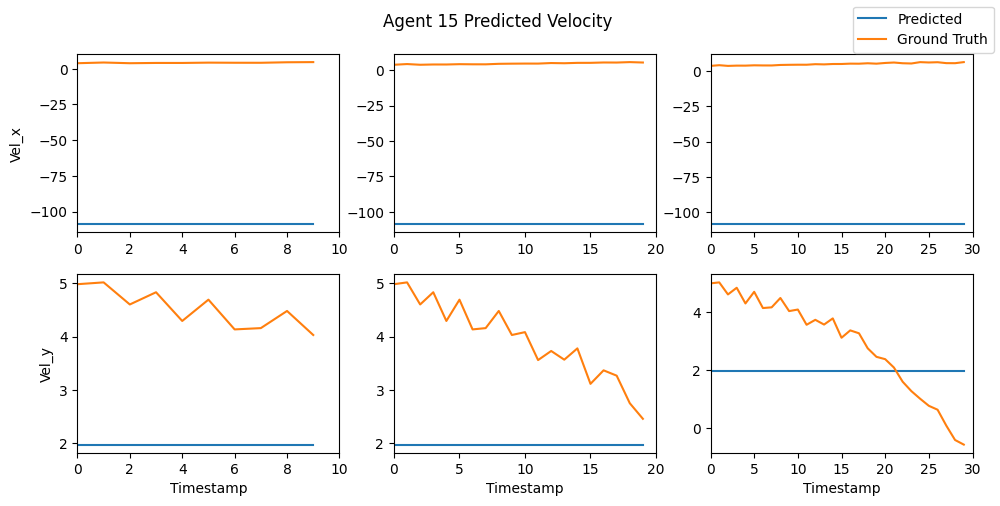

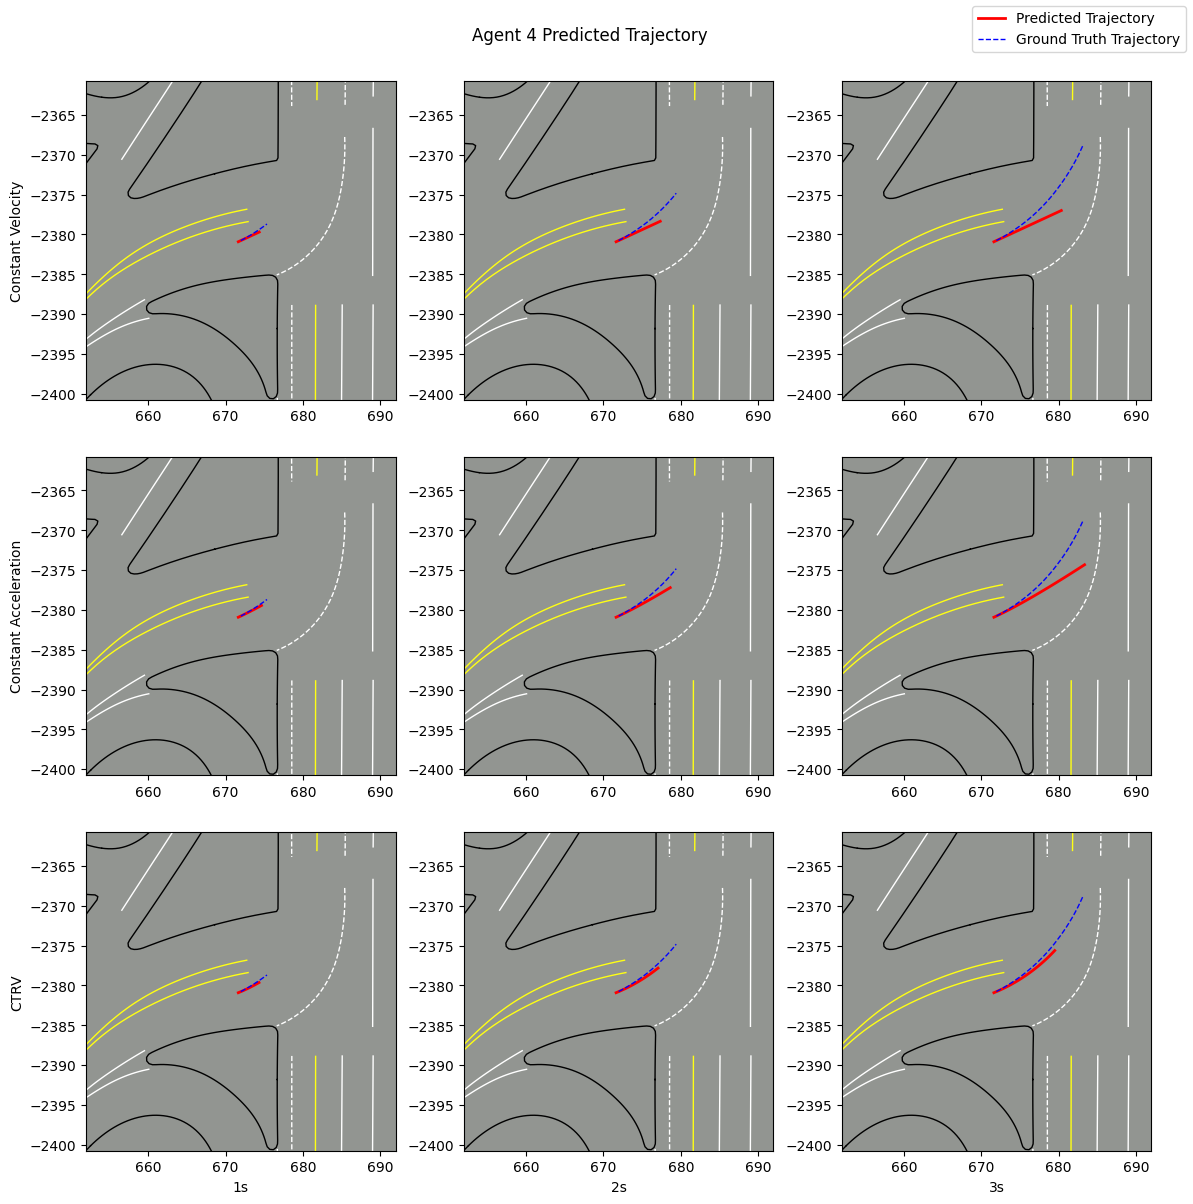

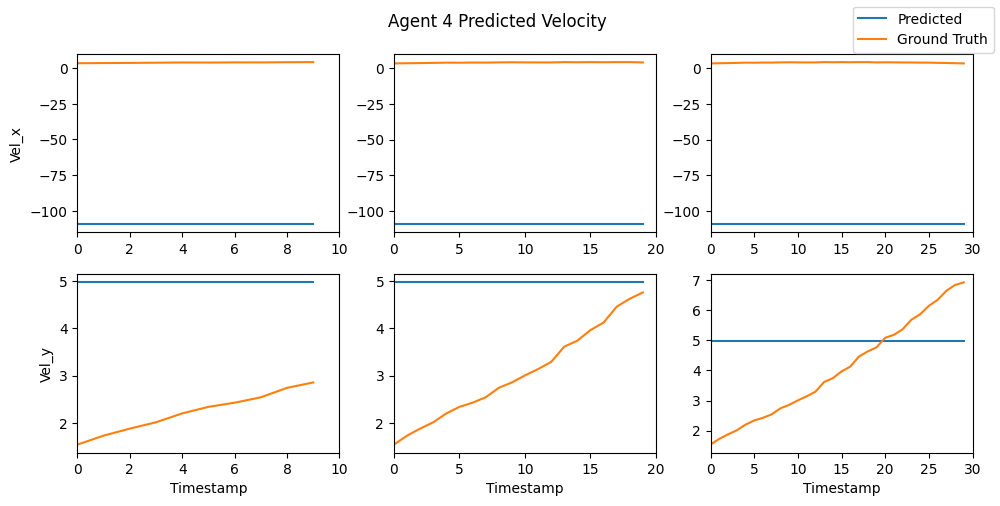

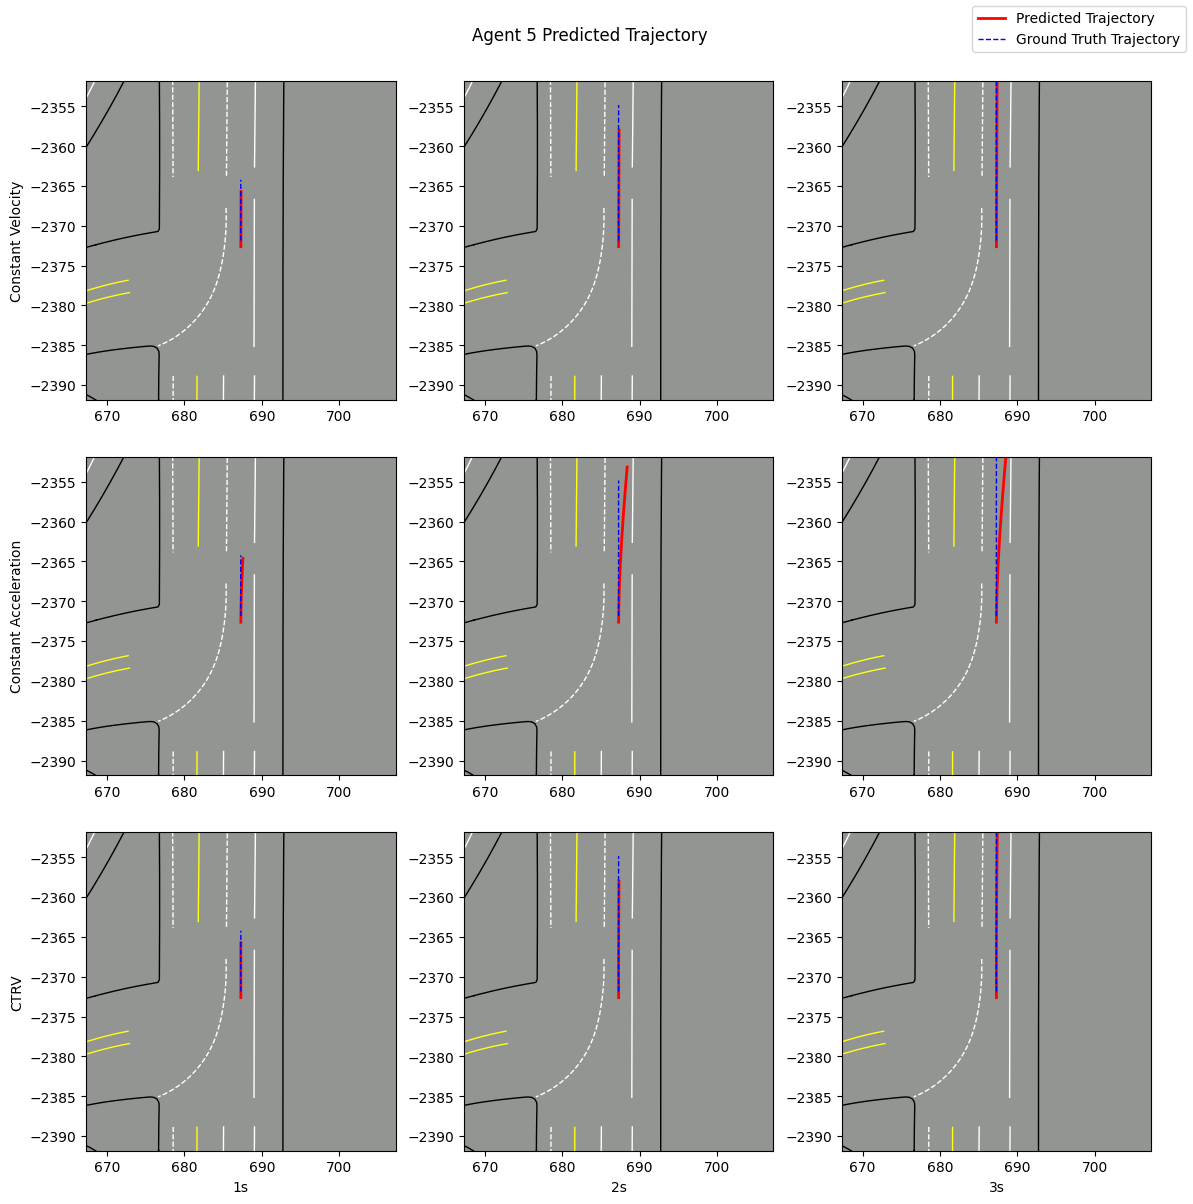

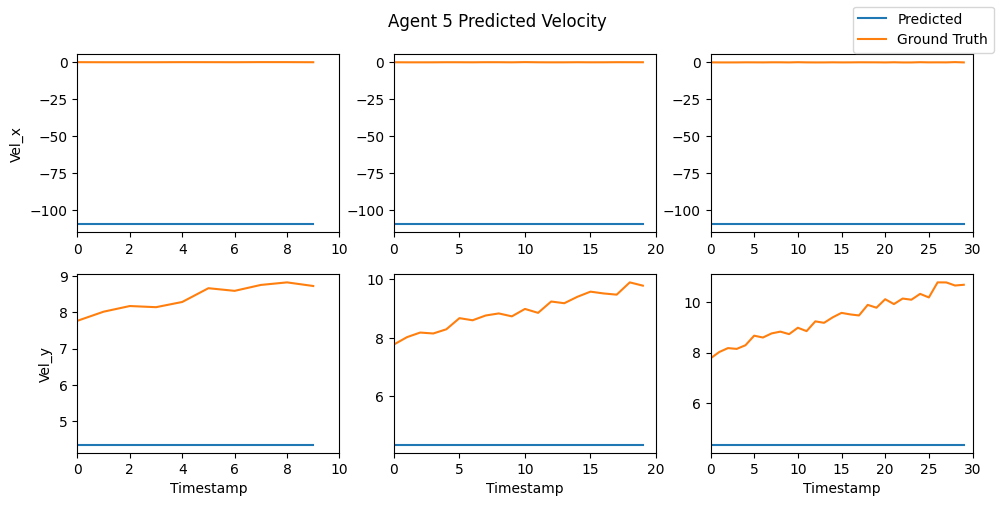

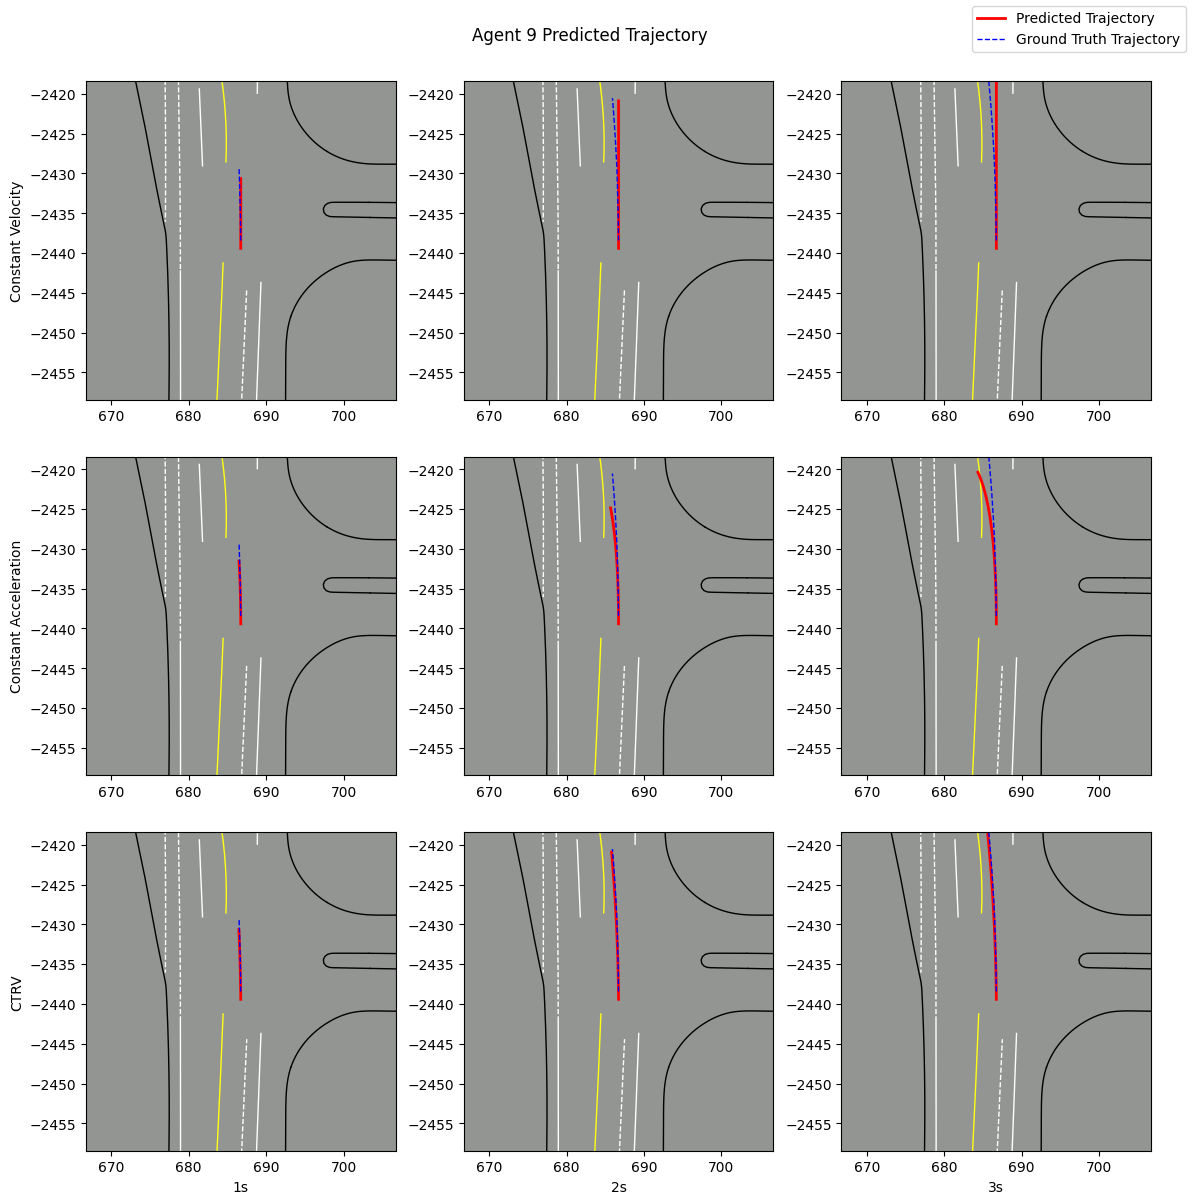

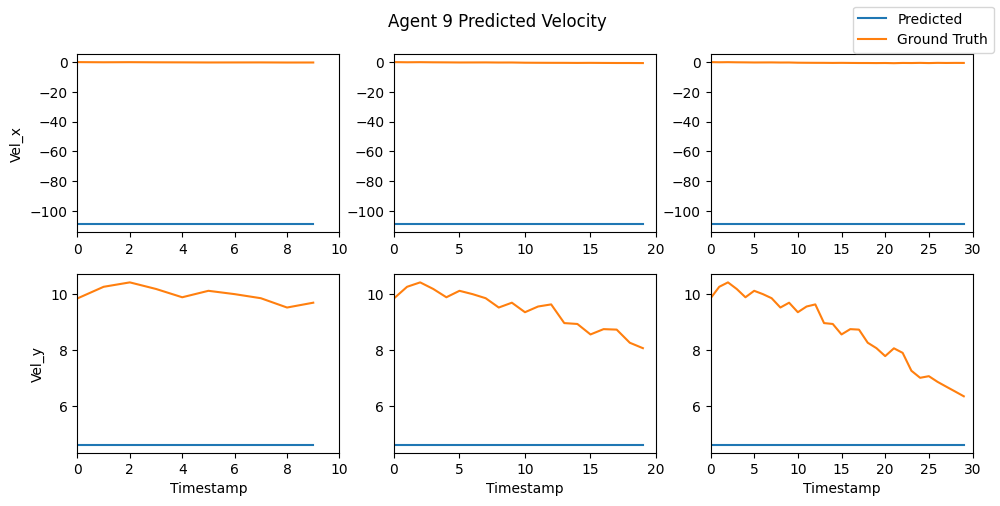

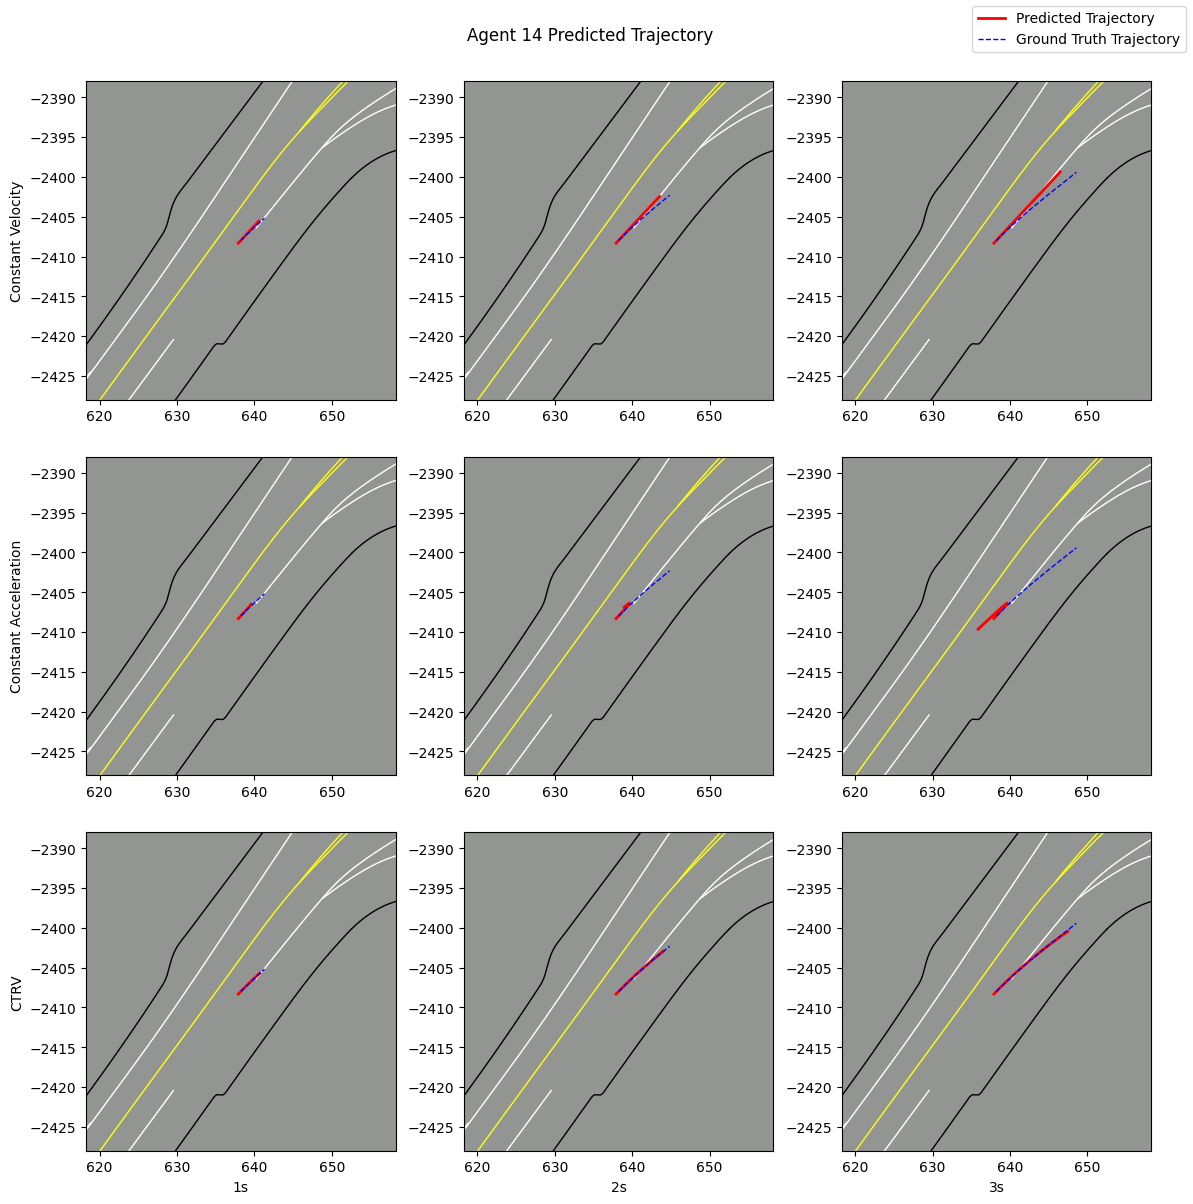

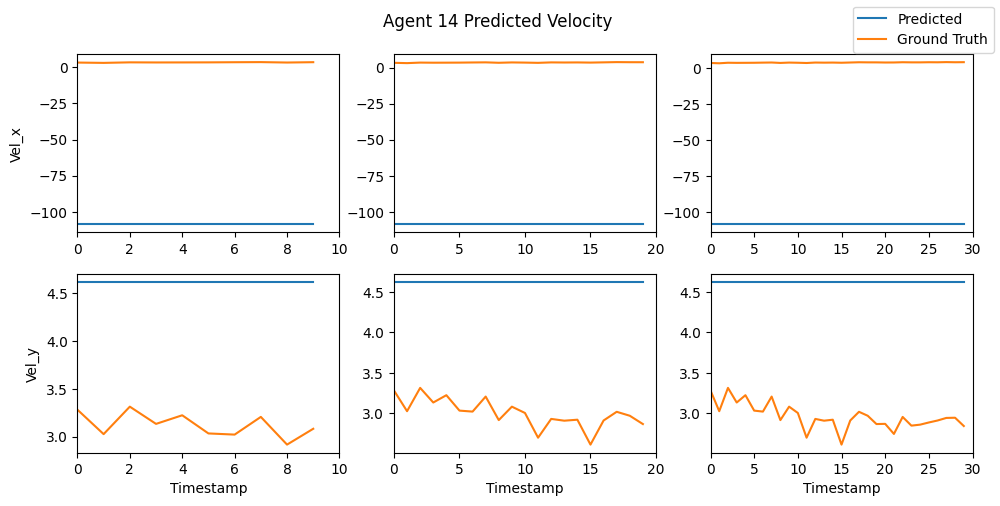

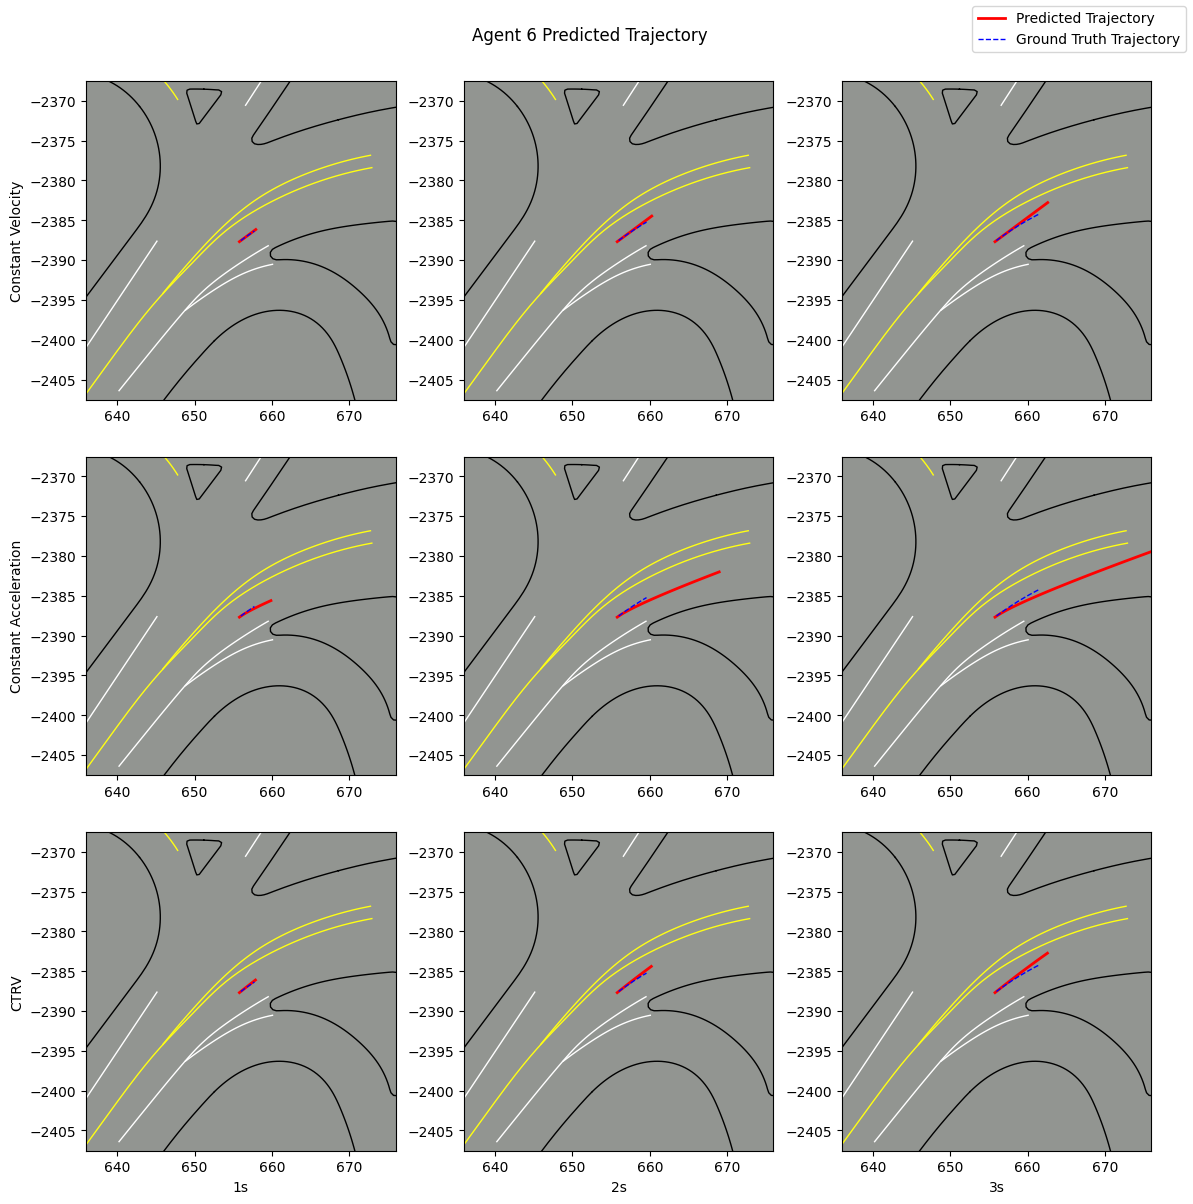

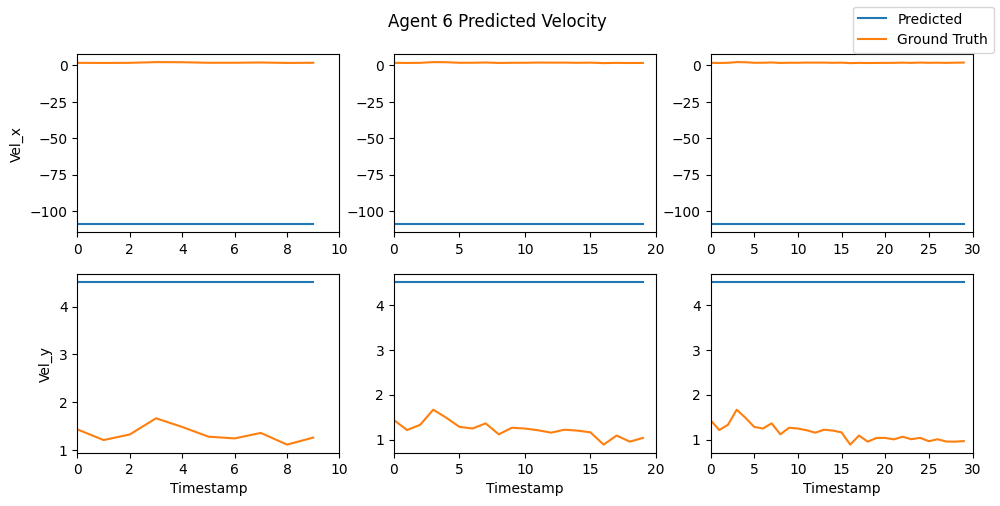

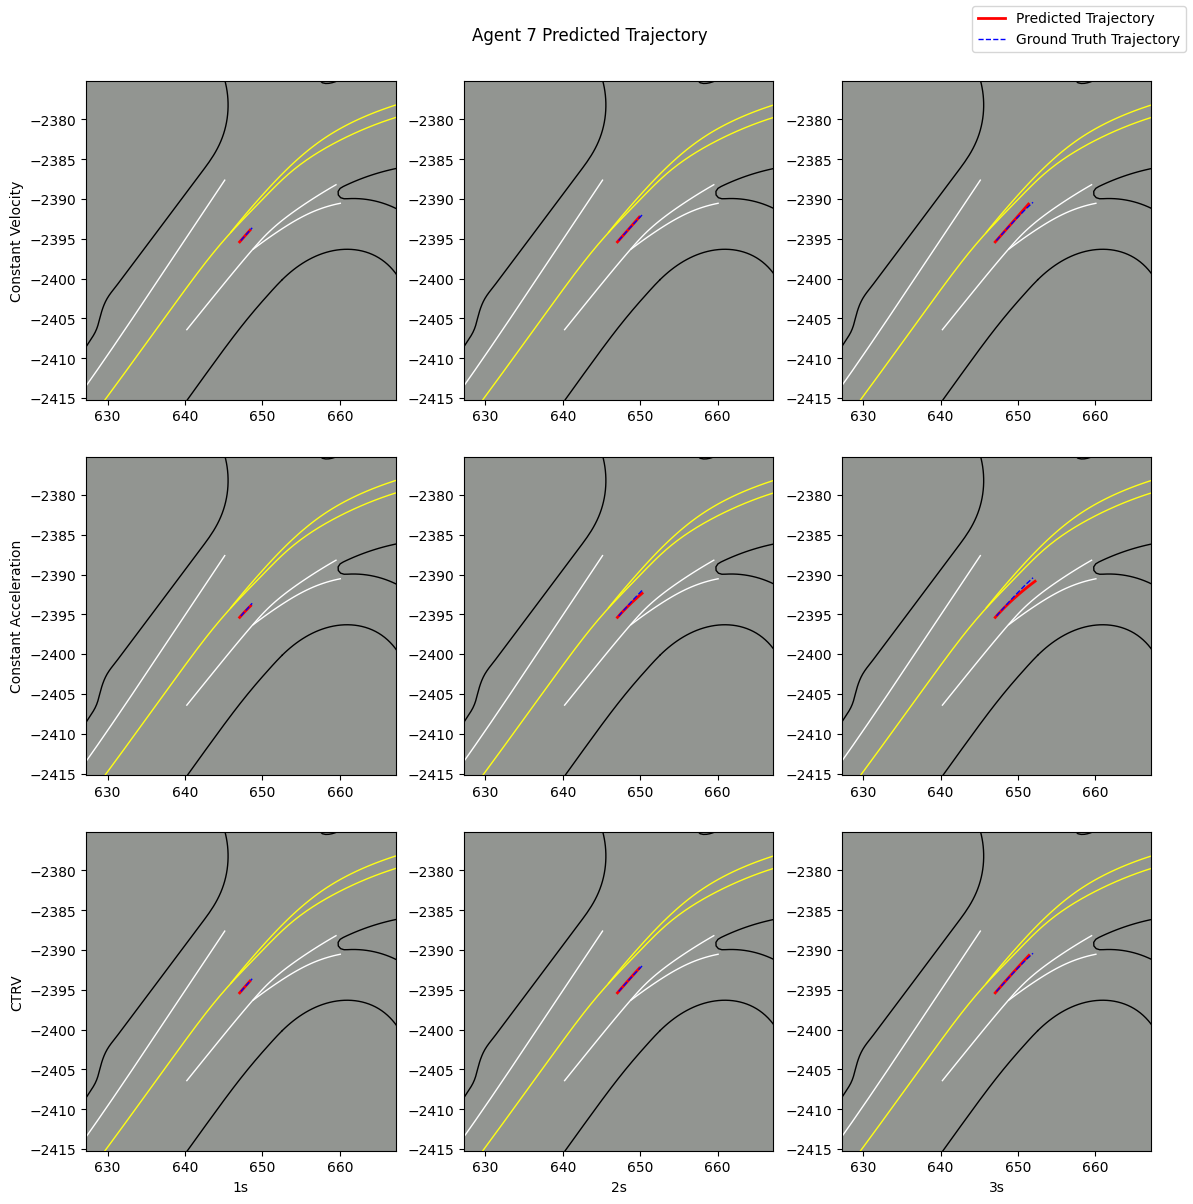

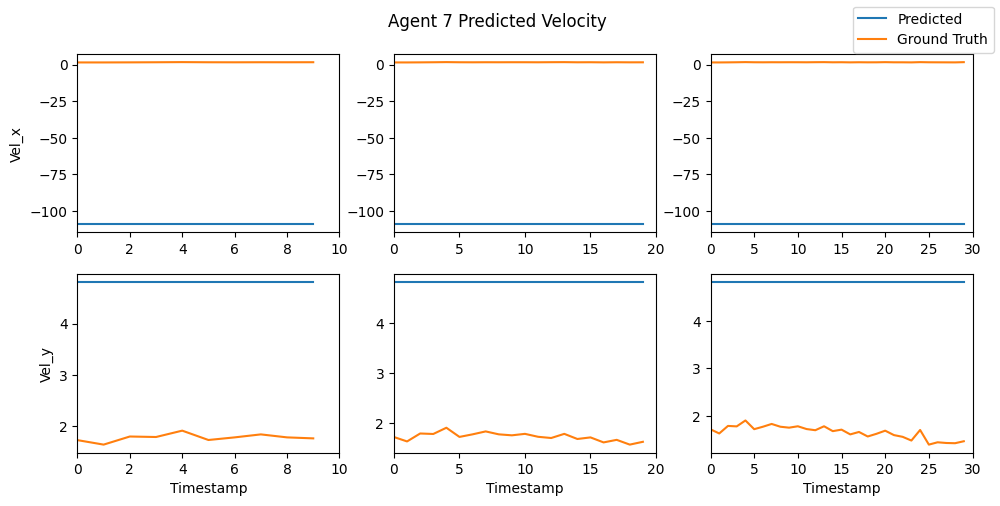

In [9]:
"""
sdc_current_state = all_agent_trajs[tracks[4]][11]
ax = plt.gca()
fig = plt.gcf()
fig.set_facecolor('xkcd:grey')
ax.set_facecolor('xkcd:grey')
for polyline in road_polylines:
    map_type = polyline[0,6]
    if map_type == 6:
        plt.plot(polyline[:, 0], polyline[:, 1], 'w', linestyle='dashed', linewidth=1)
    elif map_type == 7:
        plt.plot(polyline[:, 0], polyline[:, 1], 'w', linestyle='solid', linewidth=1)
    elif map_type == 8:
        plt.plot(polyline[:, 0], polyline[:, 1], 'w', linestyle='solid', linewidth=1)
    elif map_type == 9:
        plt.plot(polyline[:, 0], polyline[:, 1], 'xkcd:yellow', linestyle='dashed', linewidth=1)
    elif map_type == 10:
        plt.plot(polyline[:, 0], polyline[:, 1], 'xkcd:yellow', linestyle='dashed', linewidth=1)
    elif map_type == 11:
        plt.plot(polyline[:, 0], polyline[:, 1], 'xkcd:yellow', linestyle='solid', linewidth=1)
    elif map_type == 12:
        plt.plot(polyline[:, 0], polyline[:, 1], 'xkcd:yellow', linestyle='solid', linewidth=1)
    elif map_type == 13:
        plt.plot(polyline[:, 0], polyline[:, 1], 'xkcd:yellow', linestyle='dotted', linewidth=1)
    elif map_type == 15:
        plt.plot(polyline[:, 0], polyline[:, 1], 'k', linewidth=1)
    elif map_type == 16:
        plt.plot(polyline[:, 0], polyline[:, 1], 'k', linewidth=1)
ax.axis([-70+ sdc_current_state[0], 70+ sdc_current_state[0], -70+ sdc_current_state[1], 70 + sdc_current_state[1]])
plt.show()
# filename = './viz.png'
# plt.savefig(filename)
# plt.close()
"""

import sys

sys.path.append("../")
from utils import draw_pred_traj
import json
import pandas as pd

# post processing
enable_viz = True
viz_pred_vel = True
enable_save = True
plt.ioff()
models2viz = [
    "const_vel",
    "const_acc",
    "ctrv",
]
agents2viz = [  # index of trakcs to viz
    22,
    15,
    4,
    5,
    9,
    14,
    6,
    7,
]
horizon2viz = [
    10,
    20,
    30,
]

# visualize
if enable_viz:
    # - for each agent, visualize for each horizon:
    #   1. predicted trajectory, ground truth, and the map
    #   2. predicted velocity and ground truth

    for i, track in enumerate(agents2viz):
        fig, axs = plt.subplots(len(models2viz), len(horizon2viz), figsize=(12, 12))
        fig.suptitle(f"Agent {track} Predicted Trajectory")
        fig.tight_layout(pad=2.0)
        fig.subplots_adjust(left=0.08)
        if "const_acc" in models2viz and viz_pred_vel:
            fig2, axs2 = plt.subplots(2, len(horizon2viz), figsize=(10, 5))
            fig2.suptitle(f"Agent {track} Predicted Velocity")
            fig2.tight_layout(pad=1.0)
            fig2.subplots_adjust(left=0.08, bottom=0.1)

        for j, horizon in enumerate(horizon2viz):
            if "const_vel" in models2viz:
                draw_pred_traj(
                    fig,
                    axs[0][j],
                    predict_result[track][horizon]["const_vel"],
                    all_gt_future[horizon][track],
                    road_polylines,
                )
            if "const_acc" in models2viz:
                draw_pred_traj(
                    fig,
                    axs[1][j],
                    predict_result[track][horizon]["const_acc"],
                    all_gt_future[horizon][track],
                    road_polylines,
                )
            if "ctrv" in models2viz:
                draw_pred_traj(
                    fig,
                    axs[2][j],
                    predict_result[track][horizon]["ctrv"],
                    all_gt_future[horizon][track],
                    road_polylines,
                )
            if "const_acc" in models2viz and viz_pred_vel:
                axs2[0][j].set_xlim(0, horizon)
                axs2[1][j].set_xlim(0, horizon)
                axs2[0][j].plot(predict_result[track][horizon]["const_acc"][:, 2], label="Precited Vel_x")
                axs2[0][j].plot(all_gt_future[horizon][track][:, 7], label="Ground Truth Vel_y")
                axs2[1][j].plot(predict_result[track][horizon]["const_acc"][:, 3], label="Precited Vel_y")
                axs2[1][j].plot(all_gt_future[horizon][track][:, 8], label="Ground Truth Vel_y")
                axs2[1][j].set_xlabel(f"Timestamp")
        if "const_vel" in models2viz:
            axs[0][0].set_ylabel("Constant Velocity")
        if "const_acc" in models2viz:
            axs[1][0].set_ylabel("Constant Acceleration")
            if viz_pred_vel:
                axs2[0][0].set_ylabel("Vel_x")
                axs2[1][0].set_ylabel("Vel_y")
        if "ctrv" in models2viz:
            axs[2][0].set_ylabel("CTRV")
        for i, horizon in enumerate(horizon2viz):
            axs[-1][i].set_xlabel(f"{int(horizon/10)}s")
        # fig.show()
        # plt.show()
        handles, labels = axs[0][0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="upper right")
        fig.savefig(os.path.join(sys.path[0], f"./results/predicted_traj_agent{track}.png"))
        if "const_acc" in models2viz and viz_pred_vel:
            fig2.legend(["Predicted", "Ground Truth"], loc="upper right")
            fig2.savefig(os.path.join(sys.path[0], f"./results/predicted_vel_agent{track}.png"))

# save the result
if enable_save:
    metric_json = json.dumps(metric_all, indent=2)
    result_path = os.path.join(sys.path[0], "./results")
    if not os.path.exists(result_path):
        os.makedirs(result_path)
    open(os.path.join(result_path, "metrics.json"), "w").write(metric_json)

    df = pd.DataFrame.from_dict(
        {
            (k1, k2, k3, k4): metric_all[k1][k2][k3][k4]
            for k1 in metric_all.keys()
            for k2 in metric_all[k1].keys()
            for k3 in metric_all[k1][k2].keys()
            for k4 in metric_all[k1][k2][k3].keys()
        },
        orient="index",
    )
    # df.index = pd.MultiIndex.from_tuples(df.index, names=["agent", "method", "period", "metric"])
    # excel_file_path = os.path.join(result_path, "metric.xlsx")
    # df.to_excel(excel_file_path)

    # Convert the nested dictionary to a DataFrame
    df = df.reset_index()
    df.columns = ["multi_index", "value"]
    df[["agent", "horizon", "metric", "method"]] = pd.DataFrame(df["multi_index"].tolist(), index=df.index)
    df.drop("multi_index", axis=1, inplace=True)
    pivot_df = df.pivot_table(index="agent", columns=["horizon", "metric", "method"], values="value", aggfunc="first")
    pivot_df = pivot_df.reindex(sorted(pivot_df.columns), axis=1)

    excel_file_path = os.path.join(result_path, "metrics.xlsx")
    pivot_df.to_excel(excel_file_path)

    # os.system("rm results.zip")
    # os.system("zip -r results.zip results")